In [1]:
import numpy as np
import os

DATA_PATH = 'Anuran_Calls_(MFCCs)'

In [2]:
import pandas as pd

def load_csv(path = DATA_PATH):
    csv_path = os.path.join(path, 'Frogs_MFCCs.csv')
    return pd.read_csv(csv_path)

In [3]:
df = load_csv()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7195 entries, 0 to 7194
Data columns (total 26 columns):
MFCCs_ 1    7195 non-null float64
MFCCs_ 2    7195 non-null float64
MFCCs_ 3    7195 non-null float64
MFCCs_ 4    7195 non-null float64
MFCCs_ 5    7195 non-null float64
MFCCs_ 6    7195 non-null float64
MFCCs_ 7    7195 non-null float64
MFCCs_ 8    7195 non-null float64
MFCCs_ 9    7195 non-null float64
MFCCs_10    7195 non-null float64
MFCCs_11    7195 non-null float64
MFCCs_12    7195 non-null float64
MFCCs_13    7195 non-null float64
MFCCs_14    7195 non-null float64
MFCCs_15    7195 non-null float64
MFCCs_16    7195 non-null float64
MFCCs_17    7195 non-null float64
MFCCs_18    7195 non-null float64
MFCCs_19    7195 non-null float64
MFCCs_20    7195 non-null float64
MFCCs_21    7195 non-null float64
MFCCs_22    7195 non-null float64
Family      7195 non-null object
Genus       7195 non-null object
Species     7195 non-null object
RecordID    7195 non-null int64
dtypes: float6

In [5]:
# Number of instances by class
df.loc[:,'Family'].value_counts()

Leptodactylidae    4420
Hylidae            2165
Dendrobatidae       542
Bufonidae            68
Name: Family, dtype: int64

In [6]:
df.loc[:,'Genus'].value_counts()

Adenomera        4150
Hypsiboas        1593
Ameerega          542
Dendropsophus     310
Leptodactylus     270
Scinax            148
Osteocephalus     114
Rhinella           68
Name: Genus, dtype: int64

In [7]:
df.loc[:,'Species'].value_counts()

AdenomeraHylaedactylus    3478
HypsiboasCordobae         1121
AdenomeraAndre             672
Ameeregatrivittata         542
HypsiboasCinerascens       472
HylaMinuta                 310
LeptodactylusFuscus        270
ScinaxRuber                148
OsteocephalusOophagus      114
Rhinellagranulosa           68
Name: Species, dtype: int64

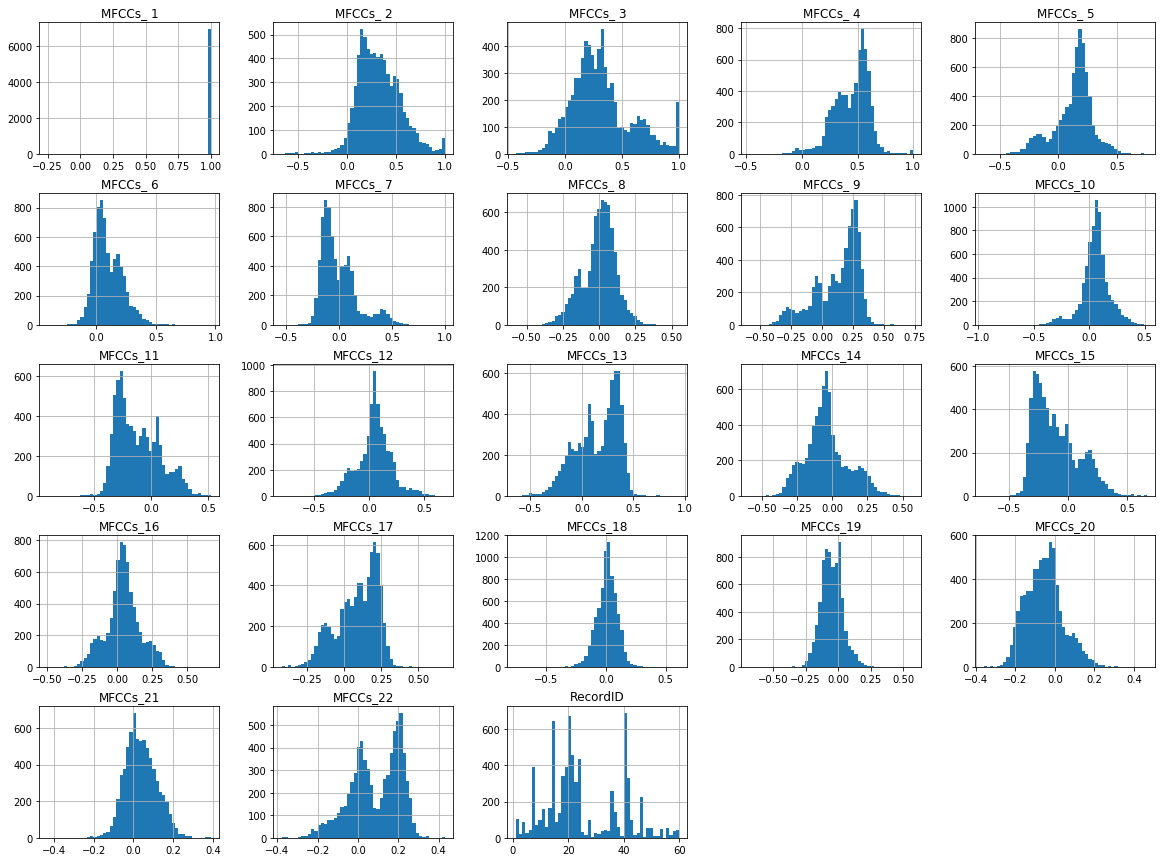

In [83]:
%matplotlib inline
import matplotlib.pyplot as plt
df.hist(bins=50, figsize=(20,15))
plt.show()

In [8]:
# Right now only choosing species
X, Y = df.loc[:,'MFCCs_ 1':'MFCCs_22'], df.loc[:, 'Species']

In [9]:
from imblearn.under_sampling import RandomUnderSampler

dict = {
    'AdenomeraHylaedactylus': 1121
}

rus = RandomUnderSampler(ratio=dict)
X_resampled, Y_resampled = rus.fit_sample(X, Y)

print(str(X_resampled.size))
print(str(Y_resampled.size))

print(str(X.size))
print(str(Y.size))

print(pd.value_counts(Y_resampled))

106436
4838
158290
7195
AdenomeraHylaedactylus    1121
HypsiboasCordobae         1121
AdenomeraAndre             672
Ameeregatrivittata         542
HypsiboasCinerascens       472
HylaMinuta                 310
LeptodactylusFuscus        270
ScinaxRuber                148
OsteocephalusOophagus      114
Rhinellagranulosa           68
dtype: int64


In [10]:
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

def createOneHotEncoded(arg):
    
    # integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(arg)
    
    # binary encode
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    
    return onehot_encoded

In [176]:
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        #val_predict = (np.asarray(self.model.predict(self.validation_data[0])))
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), axis=1)
        #val_targ = self.validation_data[1]
        val_targ = np.argmax(self.validation_data[1], axis=1)
        
        _val_f1 = f1_score(val_targ, val_predict, average="weighted")
        _val_recall = recall_score(val_targ, val_predict, average="weighted")
        _val_precision = precision_score(val_targ, val_predict, average="weighted")
        
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        
        # print(" — val_f1: %f — val_precision: %f — val_recall %f" %(_val_f1, _val_precision, _val_recall))
        return

In [44]:
from keras.layers import Dense, Dropout
from keras.models import Sequential

def createModel():
    model = Sequential()

    model.add(Dense(units=32, activation='relu', input_dim=22))
    model.add(Dense(units=64, activation='relu'))
    #model.add(Dense(units=32, activation='relu'))
    
    model.add(Dense(units=10, activation='softmax')) #10 species
    
    model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
    
    return model

In [202]:
from sklearn.metrics import classification_report

N_EPOCHS = 50
BATCH_SIZE = 32

metrics = []

def trainAndTestModel(model, x_train, y_train, x_val, y_val):
    
    # Create new callback class
    metrics.append(Metrics())
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=BATCH_SIZE, epochs=N_EPOCHS, verbose=1, callbacks=[metrics[-1]])
    
    pred = model.predict(x_val, batch_size=32, verbose=0)
    y_pred = np.argmax(pred, axis=1)
    
    report = classification_report(argmax(y_val, axis=1), y_pred)
    
    #TODO: see if we need this
    #report = pandas_classification_report(np.argmax(y_val, axis=1), y_pred)
    
    print(report)
    
    return history 

In [188]:
from sklearn.metrics import classification_report
from  sklearn.metrics import precision_recall_fscore_support

np.random.seed(0)

def pandas_classification_report(y_true, y_pred):
    metrics_summary = precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred)

    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index)

    support = class_report_df.loc['support']
    total = support.sum() 
    avg[-1] = total

    class_report_df['avg / total'] = avg

    return class_report_df.T

In [203]:
from sklearn.model_selection import StratifiedKFold

# Instantiate the cross validator
skf = StratifiedKFold(n_splits=5, shuffle=True)

historyList = []
#reportList = []

for index, (train_indices, val_indices) in enumerate(skf.split(X_resampled, Y_resampled)):
    
    # Generate batches from indices
    xtrain, xval = X_resampled[train_indices], X_resampled[val_indices]
    ytrain, yval = createOneHotEncoded(Y_resampled[train_indices]), createOneHotEncoded(Y_resampled[val_indices])
    
    # Clear model, and create it
    model = None
    model = createModel()
    
    history = trainAndTestModel(model, xtrain, ytrain, xval, yval)
    
    historyList.append(history)
    

Train on 3866 samples, validate on 972 samples
Epoch 1/50
3866/3866 [==============================] - 6s 2ms/step - loss: 2.2115 - acc: 0.2245 - val_loss: 2.1059 - val_acc: 0.2521
 — val_f1: 0.137648 — val_precision: 0.297895 — val_recall 0.252058
Epoch 2/50
1408/3866 [=========>....................] - ETA: 0s - loss: 2.0759 - acc: 0.3665

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


3866/3866 [==============================] - 0s 128us/step - loss: 2.0220 - acc: 0.4087 - val_loss: 1.9488 - val_acc: 0.4321
 — val_f1: 0.278205 — val_precision: 0.206541 — val_recall 0.432099
Epoch 3/50
3866/3866 [==============================] - 1s 131us/step - loss: 1.8822 - acc: 0.4493 - val_loss: 1.8203 - val_acc: 0.4465
 — val_f1: 0.296310 — val_precision: 0.322901 — val_recall 0.446502
Epoch 4/50
3866/3866 [==============================] - 0s 127us/step - loss: 1.7535 - acc: 0.4656 - val_loss: 1.6894 - val_acc: 0.4877
 — val_f1: 0.365060 — val_precision: 0.475416 — val_recall 0.487654
Epoch 5/50
3866/3866 [==============================] - 0s 128us/step - loss: 1.6177 - acc: 0.5362 - val_loss: 1.5528 - val_acc: 0.6019
 — val_f1: 0.510483 — val_precision: 0.497866 — val_recall 0.601852
Epoch 6/50
3866/3866 [==============================] - 0s 129us/step - loss: 1.4837 - acc: 0.6342 - val_loss: 1.4246 - val_acc: 0.6523
 — val_f1: 0.552025 — val_precision: 0.523134 — val_recall 

3866/3866 [==============================] - 1s 132us/step - loss: 0.3670 - acc: 0.8968 - val_loss: 0.3867 - val_acc: 0.8837
 — val_f1: 0.872864 — val_precision: 0.870935 — val_recall 0.883745
Epoch 43/50
3866/3866 [==============================] - 1s 190us/step - loss: 0.3590 - acc: 0.8963 - val_loss: 0.3790 - val_acc: 0.8909
 — val_f1: 0.881427 — val_precision: 0.879696 — val_recall 0.890947
Epoch 44/50
3866/3866 [==============================] - 1s 140us/step - loss: 0.3535 - acc: 0.9025 - val_loss: 0.3747 - val_acc: 0.8879
 — val_f1: 0.877929 — val_precision: 0.875949 — val_recall 0.887860
Epoch 45/50
3866/3866 [==============================] - 1s 141us/step - loss: 0.3470 - acc: 0.9051 - val_loss: 0.3683 - val_acc: 0.8930
 — val_f1: 0.882335 — val_precision: 0.880032 — val_recall 0.893004
Epoch 46/50
3866/3866 [==============================] - 1s 152us/step - loss: 0.3412 - acc: 0.9056 - val_loss: 0.3645 - val_acc: 0.8940
 — val_f1: 0.885867 — val_precision: 0.896075 — val_rec

3868/3868 [==============================] - 1s 227us/step - loss: 0.5130 - acc: 0.8356 - val_loss: 0.5231 - val_acc: 0.8072
 — val_f1: 0.784870 — val_precision: 0.806018 — val_recall 0.807216
Epoch 30/50
3868/3868 [==============================] - 1s 152us/step - loss: 0.4992 - acc: 0.8400 - val_loss: 0.5099 - val_acc: 0.8134
 — val_f1: 0.791088 — val_precision: 0.805920 — val_recall 0.813402
Epoch 31/50
3868/3868 [==============================] - 1s 166us/step - loss: 0.4859 - acc: 0.8472 - val_loss: 0.4966 - val_acc: 0.8237
 — val_f1: 0.803066 — val_precision: 0.815565 — val_recall 0.823711
Epoch 32/50
3868/3868 [==============================] - 1s 167us/step - loss: 0.4740 - acc: 0.8521 - val_loss: 0.4840 - val_acc: 0.8289
 — val_f1: 0.811121 — val_precision: 0.820960 — val_recall 0.828866
Epoch 33/50
3868/3868 [==============================] - 1s 191us/step - loss: 0.4624 - acc: 0.8581 - val_loss: 0.4731 - val_acc: 0.8289
 — val_f1: 0.812326 — val_precision: 0.820817 — val_rec

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Train on 3871 samples, validate on 967 samples
Epoch 1/50
3871/3871 [==============================] - 6s 2ms/step - loss: 2.2152 - acc: 0.2268 - val_loss: 2.1350 - val_acc: 0.2368
 — val_f1: 0.102801 — val_precision: 0.071130 — val_recall 0.236815
Epoch 2/50
3871/3871 [==============================] - 1s 160us/step - loss: 2.0532 - acc: 0.2836 - val_loss: 1.9791 - val_acc: 0.3433
 — val_f1: 0.216621 — val_precision: 0.158237 — val_recall 0.343330
Epoch 3/50
3871/3871 [==============================] - 1s 166us/step - loss: 1.9063 - acc: 0.3849 - val_loss: 1.8448 - val_acc: 0.4085
 — val_f1: 0.271380 — val_precision: 0.206858 — val_recall 0.408480
Epoch 4/50
3871/3871 [==============================] - 1s 199us/step - loss: 1.7786 - acc: 0.4379 - val_loss: 1.7233 - val_acc: 0.4571
 — val_f1: 0.314264 — val_precision: 0.254026 — val_recall 0.457084
Epoch 5/50
3871/3871 [==============================] - 1s 192us/step - loss: 1.6599 - acc: 0.4591 - val_loss: 1.6130 - val_acc: 0.4581
 — 

3871/3871 [==============================] - 1s 141us/step - loss: 0.3723 - acc: 0.9026 - val_loss: 0.3792 - val_acc: 0.9018
 — val_f1: 0.889695 — val_precision: 0.891942 — val_recall 0.901758
Epoch 42/50
3871/3871 [==============================] - 1s 157us/step - loss: 0.3650 - acc: 0.9057 - val_loss: 0.3724 - val_acc: 0.9018
 — val_f1: 0.889980 — val_precision: 0.891700 — val_recall 0.901758
Epoch 43/50
3871/3871 [==============================] - 1s 171us/step - loss: 0.3581 - acc: 0.9052 - val_loss: 0.3650 - val_acc: 0.9018
 — val_f1: 0.889872 — val_precision: 0.891623 — val_recall 0.901758
Epoch 44/50
3871/3871 [==============================] - 1s 162us/step - loss: 0.3509 - acc: 0.9080 - val_loss: 0.3605 - val_acc: 0.9028
 — val_f1: 0.890834 — val_precision: 0.892378 — val_recall 0.902792
Epoch 45/50
3871/3871 [==============================] - 1s 150us/step - loss: 0.3455 - acc: 0.9088 - val_loss: 0.3542 - val_acc: 0.9028
 — val_f1: 0.891014 — val_precision: 0.892995 — val_rec

3873/3873 [==============================] - 1s 170us/step - loss: 0.4470 - acc: 0.8784 - val_loss: 0.4167 - val_acc: 0.8912
 — val_f1: 0.870523 — val_precision: 0.884716 — val_recall 0.891192
Epoch 29/50
3873/3873 [==============================] - 1s 163us/step - loss: 0.4337 - acc: 0.8817 - val_loss: 0.4042 - val_acc: 0.9016
 — val_f1: 0.885998 — val_precision: 0.889720 — val_recall 0.901554
Epoch 30/50
3873/3873 [==============================] - 1s 163us/step - loss: 0.4214 - acc: 0.8864 - val_loss: 0.3942 - val_acc: 0.8964
 — val_f1: 0.879062 — val_precision: 0.883108 — val_recall 0.896373
Epoch 31/50
3873/3873 [==============================] - 1s 165us/step - loss: 0.4102 - acc: 0.8879 - val_loss: 0.3848 - val_acc: 0.8984
 — val_f1: 0.882603 — val_precision: 0.886260 — val_recall 0.898446
Epoch 32/50
3873/3873 [==============================] - 1s 154us/step - loss: 0.3993 - acc: 0.8913 - val_loss: 0.3786 - val_acc: 0.8995
 — val_f1: 0.881736 — val_precision: 0.891914 — val_rec

3874/3874 [==============================] - 1s 159us/step - loss: 0.7989 - acc: 0.7574 - val_loss: 0.7990 - val_acc: 0.7656
 — val_f1: 0.701992 — val_precision: 0.749411 — val_recall 0.765560
Epoch 16/50
3874/3874 [==============================] - 1s 159us/step - loss: 0.7615 - acc: 0.7664 - val_loss: 0.7631 - val_acc: 0.7718
 — val_f1: 0.714810 — val_precision: 0.720954 — val_recall 0.771784
Epoch 17/50
3874/3874 [==============================] - 1s 154us/step - loss: 0.7280 - acc: 0.7772 - val_loss: 0.7316 - val_acc: 0.7842
 — val_f1: 0.728169 — val_precision: 0.730197 — val_recall 0.784232
Epoch 18/50
3874/3874 [==============================] - 1s 154us/step - loss: 0.6973 - acc: 0.7876 - val_loss: 0.7030 - val_acc: 0.7946
 — val_f1: 0.745654 — val_precision: 0.751043 — val_recall 0.794606
Epoch 19/50
3874/3874 [==============================] - 1s 153us/step - loss: 0.6701 - acc: 0.7945 - val_loss: 0.6799 - val_acc: 0.8050
 — val_f1: 0.757606 — val_precision: 0.754000 — val_rec

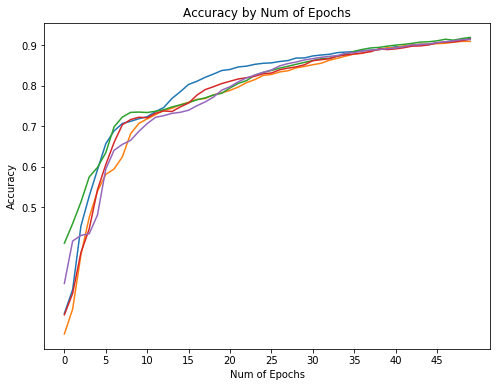

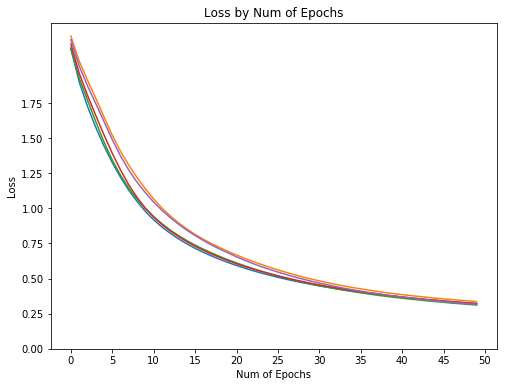

In [122]:
plotAccuracy(historyList)
plotLoss(historyList)


In [118]:
%matplotlib inline
import matplotlib.pyplot as plt

def plotAccuracy(results):
    plt.figure(0)
    
    for val in results:
        plt.plot(val.history['acc'])
        
    plt.xticks(np.arange(0, N_EPOCHS, 5.0))
    plt.yticks(np.arange(0.5, 1.0, 0.1))
    plt.rcParams['figure.figsize'] = (8, 6)
    plt.xlabel("Num of Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy by Num of Epochs")

    plt.show()
    
def plotLoss(results):
    plt.figure(1)
    
    for val in results:
        plt.plot(val.history['loss'])
        
    plt.xticks(np.arange(0, 55, 5.0))
    plt.yticks(np.arange(0, 2, 0.25))
    plt.rcParams['figure.figsize'] = (8, 6)
    plt.xlabel("Num of Epochs")
    plt.ylabel("Loss")
    plt.title("Loss by Num of Epochs")

    plt.show()
    

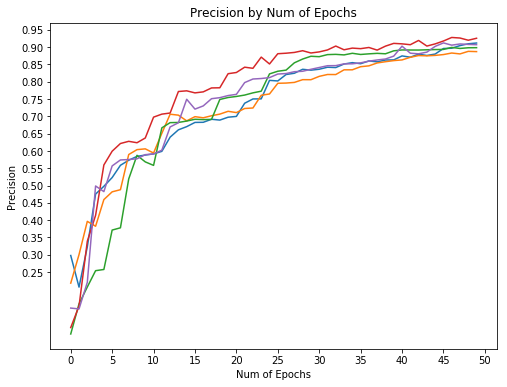

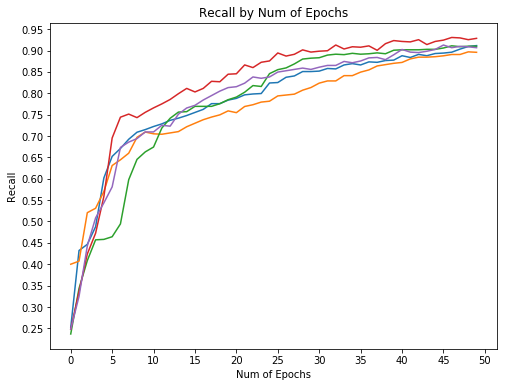

In [204]:
def plotPrecision(metrics):
    plt.figure(2)
    
    for val in metrics:
        plt.plot(val.val_precisions)
    
    plt.xticks(np.arange(0, 55, 5.0))
    plt.yticks(np.arange(0.25, 1, 0.05))
    plt.rcParams['figure.figsize'] = (8, 6)
    plt.xlabel("Num of Epochs")
    plt.ylabel("Precision")
    plt.title("Precision by Num of Epochs")
        
def plotRecall(metrics):
    plt.figure(3)
        
    for val in metrics:
        plt.plot(val.val_recalls)
    
    plt.xticks(np.arange(0, 55, 5.0))
    plt.yticks(np.arange(0.25, 1, 0.05))
    plt.rcParams['figure.figsize'] = (8, 6)
    plt.xlabel("Num of Epochs")
    plt.ylabel("Recall")
    plt.title("Recall by Num of Epochs")
    
plotPrecision(metrics)
plotRecall(metrics)
    
    

In [193]:
arr = [1,2,3]

arr[-1]

3